# 데이터 불러오기

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
cd '../gdrive/MyDrive/SSAC/3조'

/gdrive/.shortcut-targets-by-id/15_BxZVEQYCdGCGiQ5nexpWPc1cgHVe4w/3조


# CTR 예측 모델링

### 라이브러리 로드

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

In [ ]:
import joblib
import os

In [ ]:
import lightgbm as lgb

In [ ]:
from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split

In [ ]:
import warnings
warnings.filterwarnings('ignore')

## 학습 데이터 불러오기

In [ ]:
df = pd.read_csv('data/total_data.csv')
df.head()

,bid_price,content_id,imp_id,label,server_time_kst,user_id,adv_id,content_price,content_used,content_cat_1,content_cat_2,content_cat_3,content_emergency_count,content_comment_count,content_views,content_likes,content_b_pay,content_delivery_fee,content_place,content_status,adv_follower_count,adv_grade,adv_item_count,adv_views,adv_review_count,adv_comment_count,adv_pay_count,adv_parcel_post_count,adv_transfer_count,adv_chat_count,viewer_gender,viewer_age,viewer_following_count,viewer_pay_count,viewer_parcel_post_count,viewer_transfer_count,viewer_chat_count
0,50,162892746,99d1612d39112085014f,0,2021-08-31T05:02:38.277+09:00,1310312,12851816,620000,1,전자제품,600700,600700001,0,0,353,9,0,배송비 별도,강남역,판매중,2131,5285,247,4525,542,739,496,0,0,11,1,24,3,4,0,0,0
1,50,162892746,971a612d3e480cf3d178,0,2021-08-31T05:24:14.109+09:00,1310312,12851816,620000,1,전자제품,600700,600700001,0,0,353,9,0,배송비 별도,강남역,판매중,2131,5285,247,4525,542,739,496,0,0,11,1,24,3,4,0,0,0
2,50,162892746,971a612d3e480cf3d15a,0,2021-08-31T05:23:48.340+09:00,1310312,12851816,620000,1,전자제품,600700,600700001,0,0,353,9,0,배송비 별도,강남역,판매중,2131,5285,247,4525,542,739,496,0,0,11,1,24,3,4,0,0,0
3,50,162892746,99d1612d3e6b208a041a,0,2021-08-31T05:24:20.169+09:00,1310312,12851816,620000,1,전자제품,600700,600700001,0,0,353,9,0,배송비 별도,강남역,판매중,2131,5285,247,4525,542,739,496,0,0,11,1,24,3,4,0,0,0
4,50,162892746,99d1612d39112085012c,0,2021-08-31T05:01:30.062+09:00,1310312,12851816,620000,1,전자제품,600700,600700001,0,0,353,9,0,배송비 별도,강남역,판매중,2131,5285,247,4525,542,739,496,0,0,11,1,24,3,4,0,0,0


In [ ]:
df.iloc[1]

bid_price                                              50
content_id                                      162892746
imp_id                               971a612d3e480cf3d178
label                                                   0
server_time_kst             2021-08-31T05:24:14.109+09:00
user_id                                           1310312
adv_id                                           12851816
content_price                                      620000
content_used                                            1
content_cat_1                                        전자제품
content_cat_2                                      600700
content_cat_3                                   600700001
content_emergency_count                                 0
content_comment_count                                   0
content_views                                         353
content_likes                                           9
content_b_pay                                           0
content_delive

In [ ]:
df.columns

Index(['bid_price', 'content_id', 'imp_id', 'label', 'server_time_kst',
       'user_id', 'adv_id', 'content_price', 'content_used', 'content_cat_1',
       'content_cat_2', 'content_cat_3', 'content_emergency_count',
       'content_comment_count', 'content_views', 'content_likes',
       'content_b_pay', 'content_delivery_fee', 'content_place',
       'content_status', 'adv_follower_count', 'adv_grade', 'adv_item_count',
       'adv_views', 'adv_review_count', 'adv_comment_count', 'adv_pay_count',
       'adv_parcel_post_count', 'adv_transfer_count', 'adv_chat_count',
       'viewer_gender', 'viewer_age', 'viewer_following_count',
       'viewer_pay_count', 'viewer_parcel_post_count', 'viewer_transfer_count',
       'viewer_chat_count'],
      dtype='object')

## 전처리 함수 정의

In [ ]:
categorical = [
    'viewer_gender',  
    'content_used',
    'content_cat_1',
    'content_cat_2',
    'content_cat_3',
    "content_status",
    'content_delivery_fee',
    'content_b_pay', 
    #'content_place'
    ]

In [ ]:
continuous = [
    'bid_price', 
    'content_price',
    'content_emergency_count',
    'content_comment_count',     
    'content_views',       
    'content_likes',
    'adv_follower_count',
    'adv_grade',       
    'adv_item_count',         
    'adv_views',
    'adv_review_count',
    'adv_comment_count',
    'adv_pay_count',
    'adv_parcel_post_count', 
    'adv_transfer_count', 
    'adv_chat_count',
    #'viewer_age',
    'viewer_following_count',
    'viewer_pay_count',
    #"viewer_parcel_post_count",
    'viewer_transfer_count',
    'viewer_chat_count', 
    'b_pay_rate',
    'viewer_age_ch',
    # 'sec', 
    #'title_len'
    ]

In [ ]:
features = categorical + continuous

In [ ]:
def process_missing_values(df):
    for categorical_col in categorical:
        df[categorical_col] = df[categorical_col].astype(str)
        df[categorical_col] = df[categorical_col].fillna('0')
        df[categorical_col] = preprocessing.LabelEncoder().fit_transform(df[categorical_col])

    for continuous_col in continuous:
        df[continuous_col] = df[continuous_col].fillna(0)

    return df

## 전처리 진행

In [ ]:
df = process_missing_values(df)

### 평균 CTR 계산

In [ ]:
grouped_label = df.groupby('label').size()
average_ctr = float(grouped_label[1]/grouped_label.sum())
average_ctr

0.03162080806804001

## Train/Test 데이터 나누기 (8:2)

In [ ]:
train_test_df = df[['label'] + features]
train, test = train_test_split(train_test_df, test_size = 0.2, random_state=47)

X_train = train[features]
y_train = train['label']

X_test = test[features]
y_test = test['label']

In [ ]:
X_train.head()

,viewer_gender,viewer_age,content_used,content_cat_1,content_cat_2,content_cat_3,bid_price,content_price,content_emergency_count,content_comment_count,content_views,content_likes,adv_follower_count,adv_grade,adv_item_count,adv_views,adv_review_count,adv_comment_count,adv_pay_count,adv_parcel_post_count,adv_transfer_count,adv_chat_count,viewer_following_count,viewer_pay_count
695454,2,28,2,13,9,12,50,79000,0,0,64,2,1183,1014,467,46582,105,774,14,175,2,0,7,1
769462,2,35,0,10,69,136,50,400000,0,0,355,5,357,546,403,1507,58,124,130,0,2,11,0,15
671811,1,24,0,13,5,7,50,29000,0,0,101,1,48,254,840,114,26,29,38,0,0,0,3,1
522807,2,38,0,4,21,36,50,10000000,0,1,5551,38,29,520,53,805,52,3,10,9,0,14,1,0
433425,1,32,0,4,24,43,55,290000,0,0,303,4,6,246,10,69,25,43,18,0,0,1,0,0


# LightGBM 학습

In [ ]:
model = lgb.LGBMClassifier(n_estimators=1000,
    learning_rate=0.1,
    num_leaves=100,
    max_depth=15,
    zero_as_missing=True,
    n_jobs=os.cpu_count(),
    objective='binary')

model.fit(X=X_train, y=y_train)

LGBMClassifier(max_depth=15, n_estimators=1000, n_jobs=2, num_leaves=100,
               objective='binary', zero_as_missing=True)

# 학습된 모델 평가

In [ ]:
avg_ctr = average_ctr
prior = log_loss(y_train, [avg_ctr]*len(y_train))

pred = model.predict_proba(X_test)[:, 1]
classifier = log_loss(y_test, pred)

rig = (prior - classifier) / prior

print(f"Baseline: {avg_ctr}")
print(f"RIG: {rig}")

Baseline: 0.03162080806804001
RIG: 0.033992691276513394


In [ ]:
# avg_ctr = average_ctr
# prior = log_loss(y_train, [avg_ctr]*len(y_train))

# pred = model.predict_proba(X_test)[:, 1]
# classifier = log_loss(y_test, pred)

# rig = (prior - classifier) / prior

# print(f"Baseline: {avg_ctr}")
# print(f"RIG: {rig}")

# Baseline: 0.02417469679154155
# RIG: 0.06544446615807319

Baseline: 0.02417469679154155
RIG: 0.06544446615807319


### feature importance 확인

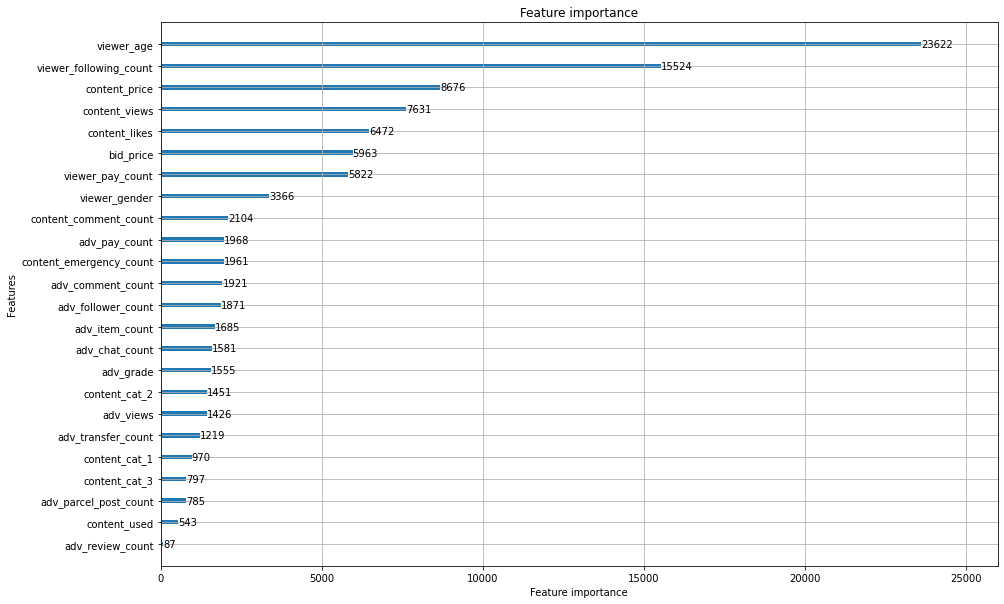

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
lgb.plot_importance(model, ax=ax)

### 모델 저장

In [ ]:
#joblib.dump(model, 'temp/model.pkl')

['model.pkl']

# 예측 및 추천

## 모델 불러오기

In [ ]:
#model = joblib.load('temp/model.pkl')

## 유저에게 보여줄 광고 후보군 생성

In [ ]:
candidate_features = [
    'bid_price', 
    'content_id',
    'content_price',
    'content_used', 
    'content_cat_1',
    'content_cat_2', 
    'content_cat_3', 
    'content_emergency_count',
    'content_comment_count', 
    'content_views', 
    'content_likes',    
    'adv_follower_count', 
    'adv_grade', 
    'adv_item_count',
    'adv_views', 
    'adv_review_count', 
    'adv_comment_count', 
    'adv_pay_count',
    'adv_parcel_post_count', 
    'adv_transfer_count', 
    'adv_chat_count']

In [ ]:
#candidates = df[:1000].drop_duplicates(['content_id'], keep='first')
candidates = df.drop_duplicates(['content_id'], keep='first')

candidates_df = candidates[candidate_features]
candidates_df.reset_index(drop=True, inplace=True)
candidates_df.head()

,bid_price,content_id,content_price,content_used,content_cat_1,content_cat_2,content_cat_3,content_emergency_count,content_comment_count,content_views,content_likes,adv_follower_count,adv_grade,adv_item_count,adv_views,adv_review_count,adv_comment_count,adv_pay_count,adv_parcel_post_count,adv_transfer_count,adv_chat_count
0,50,162892746,620000,0,17,64,123,0,0,353,9,2131,5285,247,4525,542,739,496,0,0,11
1,50,139123532,519000,0,17,64,123,0,1,9188,144,2131,5285,247,4525,542,739,496,0,0,11
2,70,139128764,629000,0,17,64,123,0,6,22132,681,2131,5285,247,4525,542,739,496,0,0,11
3,70,137073840,459000,0,17,64,123,3,4,29357,1008,2131,5285,247,4525,542,739,496,0,0,11
4,60,161754879,375000,0,17,64,123,0,0,593,19,2131,5285,247,4525,542,739,496,0,0,11


- 이미지 url 추가

In [ ]:
candidates_df['content_img_url'] = candidates_df['content_id'].apply(lambda x : f'https://media.bunjang.co.kr/product/{x}_...')
candidates_df.head()

,bid_price,content_id,content_price,content_used,content_cat_1,content_cat_2,content_cat_3,content_emergency_count,content_comment_count,content_views,content_likes,adv_follower_count,adv_grade,adv_item_count,adv_views,adv_review_count,adv_comment_count,adv_pay_count,adv_parcel_post_count,adv_transfer_count,adv_chat_count,content_img_url
0,50,162892746,620000,0,17,64,123,0,0,353,9,2131,5285,247,4525,542,739,496,0,0,11,https://media.bunjang.co.kr/product/162892746_...
1,50,139123532,519000,0,17,64,123,0,1,9188,144,2131,5285,247,4525,542,739,496,0,0,11,https://media.bunjang.co.kr/product/139123532_...
2,70,139128764,629000,0,17,64,123,0,6,22132,681,2131,5285,247,4525,542,739,496,0,0,11,https://media.bunjang.co.kr/product/139128764_...
3,70,137073840,459000,0,17,64,123,3,4,29357,1008,2131,5285,247,4525,542,739,496,0,0,11,https://media.bunjang.co.kr/product/137073840_...
4,60,161754879,375000,0,17,64,123,0,0,593,19,2131,5285,247,4525,542,739,496,0,0,11,https://media.bunjang.co.kr/product/161754879_...


In [ ]:
#df.viewer_chat_count.mean()
df.viewer_following_count.mean()

9.305950774347936

In [ ]:
len(candidates_df)

1427

## 가상의 유저 생성 : 30대 남성

In [ ]:
user_demo = pd.DataFrame({
    'viewer_gender': [1],
    'viewer_age': [30],
    'viewer_following_count': [10],
    'viewer_pay_count': [3],
    'viewer_parcel_post_count': [5],
    'viewer_transfer_count': [1],
    'viewer_chat_count': [1]
})

### Input 데이터 생성 및 전처리

In [ ]:
for col in user_demo.columns:
    candidates_df[col] = user_demo[col][0]
feature_df = candidates_df
feature_df = process_missing_values(feature_df)
feature_df.head()

,bid_price,content_id,content_price,content_used,content_cat_1,content_cat_2,content_cat_3,content_emergency_count,content_comment_count,content_views,content_likes,adv_follower_count,adv_grade,adv_item_count,adv_views,adv_review_count,adv_comment_count,adv_pay_count,adv_parcel_post_count,adv_transfer_count,adv_chat_count,content_img_url,viewer_gender,viewer_age,viewer_following_count,viewer_pay_count,viewer_parcel_post_count,viewer_transfer_count,viewer_chat_count,probs,ecpm
1179,50,163156403,10000,0,11,8,87,0,0,138,16,2183,12120,7036,115655,1235,211,351,386,32,1,https://media.bunjang.co.kr/product/163156403_...,1,30,10,3,5,1,1,0.162348,8117.386925
1033,50,123987459,180000,2,14,82,81,5,0,13517,428,210,532,20,1053,54,47,115,0,0,8,https://media.bunjang.co.kr/product/123987459_...,1,30,10,3,5,1,1,0.149918,7495.889370
538,115,163068108,99000,0,10,5,135,0,0,193,1,76,576,438,280,58,109,34,387,1,1,https://media.bunjang.co.kr/product/163068108_...,1,30,10,3,5,1,1,0.041304,4749.949965
1217,100,163212102,279000,0,2,4,98,0,0,91,4,68,149,31,995,15,168,33,0,0,0,https://media.bunjang.co.kr/product/163212102_...,1,30,10,3,5,1,1,0.038124,3812.435636
521,80,162721528,58000,0,2,4,79,0,0,160,4,388,868,1787,846,88,24,47,229,1,0,https://media.bunjang.co.kr/product/162721528_...,1,30,10,3,5,1,1,0.040094,3207.504517


### 클릭 확률(CTR) 예측

In [ ]:
grouped_label = df.groupby('label').size()
average_ctr = float(grouped_label[1]/grouped_label.sum())
average_ctr

In [ ]:
feature_df = feature_df[features]
probs = model.predict_proba(feature_df)

candidates_df['probs'] = probs[:, 1]
candidates_df.head()

,bid_price,content_id,content_price,content_used,content_cat_1,content_cat_2,content_cat_3,content_emergency_count,content_comment_count,content_views,content_likes,adv_follower_count,adv_grade,adv_item_count,adv_views,adv_review_count,adv_comment_count,adv_pay_count,adv_parcel_post_count,adv_transfer_count,adv_chat_count,content_img_url,viewer_gender,viewer_age,viewer_following_count,viewer_pay_count,viewer_parcel_post_count,viewer_transfer_count,viewer_chat_count,probs,ecpm
1179,50,163156403,10000,0,3,78,173,0,0,138,16,2183,12120,7036,115655,1235,211,351,386,32,1,https://media.bunjang.co.kr/product/163156403_...,0,0,10,3,5,1,1,0.005414,8117.386925
1033,50,123987459,180000,2,6,81,167,5,0,13517,428,210,532,20,1053,54,47,115,0,0,8,https://media.bunjang.co.kr/product/123987459_...,0,0,10,3,5,1,1,0.162263,7495.889370
538,115,163068108,99000,0,2,45,41,0,0,193,1,76,576,438,280,58,109,34,387,1,1,https://media.bunjang.co.kr/product/163068108_...,0,0,10,3,5,1,1,0.004733,4749.949965
1217,100,163212102,279000,0,12,34,185,0,0,91,4,68,149,31,995,15,168,33,0,0,0,https://media.bunjang.co.kr/product/163212102_...,0,0,10,3,5,1,1,0.001033,3812.435636
521,80,162721528,58000,0,12,34,164,0,0,160,4,388,868,1787,846,88,24,47,229,1,0,https://media.bunjang.co.kr/product/162721528_...,0,0,10,3,5,1,1,0.001073,3207.504517


### eCPM을 계산하여 기대 수익이 큰 광고 순으로 정렬
$eCPM = pClick * BidPrice * 1000$

In [ ]:
candidates_df['ecpm'] = candidates_df['bid_price'] * candidates_df['probs'] * 1000
candidates_df.sort_values(by=["content_price"], ascending=False, inplace=True)
candidates_df.head()

,bid_price,content_id,content_price,content_used,content_cat_1,content_cat_2,content_cat_3,content_emergency_count,content_comment_count,content_views,content_likes,adv_follower_count,adv_grade,adv_item_count,adv_views,adv_review_count,adv_comment_count,adv_pay_count,adv_parcel_post_count,adv_transfer_count,adv_chat_count,content_img_url,viewer_gender,viewer_age,viewer_following_count,viewer_pay_count,viewer_parcel_post_count,viewer_transfer_count,viewer_chat_count,probs,ecpm
18,50,162523203,290000,2,8,41,116,3,0,11304,157,1320,1600,160,1728,161,0,0,0,0,2,https://media.bunjang.co.kr/product/162523203_...,0,0,10,3,5,1,1,0.212763,10638.147859
1281,50,133347162,17000,0,8,37,172,5,0,26061,790,543,14580,194,2577,1520,102,56,0,0,34,https://media.bunjang.co.kr/product/133347162_...,0,0,10,3,5,1,1,0.195515,9775.737910
1033,50,123987459,180000,2,6,81,167,5,0,13517,428,210,532,20,1053,54,47,115,0,0,8,https://media.bunjang.co.kr/product/123987459_...,0,0,10,3,5,1,1,0.162263,8113.130668
1395,50,135394466,23000,0,16,7,70,0,0,4667,183,365,1394,149,30227,141,51,0,365,0,1,https://media.bunjang.co.kr/product/135394466_...,0,0,10,3,5,1,1,0.085631,4281.532961
547,70,152628335,250000,0,8,41,116,0,0,6263,240,510,1229,435,1052,127,23,81,0,0,2,https://media.bunjang.co.kr/product/152628335_...,0,0,10,3,5,1,1,0.044229,3096.009934


### 추천 광고 출력

- `content_id`를 통해 광고 제목 추출하는 딕셔너리 정의

In [ ]:
ad_df = pd.read_csv('data/ad_new.csv')
id2name = ad_df[['content_id', 'name']].set_index('content_id').transpose().to_dict('records')[0]

- 30대 남성은 노트북, 핸드폰 등 전자기기 광고를 추천해줬을때 기대수익이 높음

In [ ]:
from IPython.display import HTML, display

html = ""
for idx, row in candidates_df[0:20].iterrows():
    html += f'''
        <div style="display:inline-block;min-width:150px;max-width:150px;vertical-align:top">
        <ul>
            <li>광고명: {id2name[row.content_id]}</li>
            <li>가격: {row.content_price}</li>
            <li>eCPM: {round(row.ecpm)}</li>
            <li>bid: {row.bid_price}</li>
            <li>prob: {round(row.probs, 4)}</li>
        </ul>
        <img src="{row.content_img_url}" style="width:150px;">
        </div>
        '''
    
display(HTML(html))

## 가상의 유저 생성 : 30대 여성

In [ ]:
user_demo = pd.DataFrame({
    'viewer_gender': [1],
    'viewer_age': [30],
    'viewer_following_count': [10],
    'viewer_pay_count': [3],
    'viewer_parcel_post_count': [5],
    'viewer_transfer_count': [1],
    'viewer_chat_count': [1]
})

### Input 데이터 생성 및 전처리

In [ ]:
for col in user_demo.columns:
    candidates_df[col] = user_demo[col][0]
feature_df = candidates_df
feature_df = process_missing_values(feature_df)
feature_df.head()

,bid_price,content_id,content_price,content_used,content_cat_1,content_cat_2,content_cat_3,content_emergency_count,content_comment_count,content_views,content_likes,adv_follower_count,adv_grade,adv_item_count,adv_views,adv_review_count,adv_comment_count,adv_pay_count,adv_parcel_post_count,adv_transfer_count,adv_chat_count,content_img_url,viewer_gender,viewer_age,viewer_following_count,viewer_pay_count,viewer_parcel_post_count,viewer_transfer_count,viewer_chat_count,probs,ecpm
1179,50,163156403,10000,0,11,8,87,0,0,138,16,2183,12120,7036,115655,1235,211,351,386,32,1,https://media.bunjang.co.kr/product/163156403_...,1,30,10,3,5,1,1,0.162348,8117.386925
1033,50,123987459,180000,2,14,82,81,5,0,13517,428,210,532,20,1053,54,47,115,0,0,8,https://media.bunjang.co.kr/product/123987459_...,1,30,10,3,5,1,1,0.149918,7495.889370
538,115,163068108,99000,0,10,5,135,0,0,193,1,76,576,438,280,58,109,34,387,1,1,https://media.bunjang.co.kr/product/163068108_...,1,30,10,3,5,1,1,0.041304,4749.949965
1217,100,163212102,279000,0,2,4,98,0,0,91,4,68,149,31,995,15,168,33,0,0,0,https://media.bunjang.co.kr/product/163212102_...,1,30,10,3,5,1,1,0.038124,3812.435636
521,80,162721528,58000,0,2,4,79,0,0,160,4,388,868,1787,846,88,24,47,229,1,0,https://media.bunjang.co.kr/product/162721528_...,1,30,10,3,5,1,1,0.040094,3207.504517


### 클릭 확률(CTR) 예측

In [ ]:
feature_df = feature_df[features]
probs = model.predict_proba(feature_df)

candidates_df['probs'] = probs[:, 1]
candidates_df.head()

,bid_price,content_id,content_price,content_used,content_cat_1,content_cat_2,content_cat_3,content_emergency_count,content_comment_count,content_views,content_likes,adv_follower_count,adv_grade,adv_item_count,adv_views,adv_review_count,adv_comment_count,adv_pay_count,adv_parcel_post_count,adv_transfer_count,adv_chat_count,content_img_url,viewer_gender,viewer_age,viewer_following_count,viewer_pay_count,viewer_parcel_post_count,viewer_transfer_count,viewer_chat_count,probs,ecpm
1179,50,163156403,10000,0,3,78,173,0,0,138,16,2183,12120,7036,115655,1235,211,351,386,32,1,https://media.bunjang.co.kr/product/163156403_...,0,0,10,3,5,1,1,0.005414,8117.386925
1033,50,123987459,180000,2,6,81,167,5,0,13517,428,210,532,20,1053,54,47,115,0,0,8,https://media.bunjang.co.kr/product/123987459_...,0,0,10,3,5,1,1,0.162263,7495.889370
538,115,163068108,99000,0,2,45,41,0,0,193,1,76,576,438,280,58,109,34,387,1,1,https://media.bunjang.co.kr/product/163068108_...,0,0,10,3,5,1,1,0.004733,4749.949965
1217,100,163212102,279000,0,12,34,185,0,0,91,4,68,149,31,995,15,168,33,0,0,0,https://media.bunjang.co.kr/product/163212102_...,0,0,10,3,5,1,1,0.001033,3812.435636
521,80,162721528,58000,0,12,34,164,0,0,160,4,388,868,1787,846,88,24,47,229,1,0,https://media.bunjang.co.kr/product/162721528_...,0,0,10,3,5,1,1,0.001073,3207.504517


### eCPM을 계산하여 기대 수익이 큰 광고 순으로 정렬
$eCPM = pClick * BidPrice * 1000$

In [ ]:
candidates_df['ecpm'] = candidates_df['bid_price'] * candidates_df['probs'] * 1000
candidates_df.sort_values(by=['ecpm'], ascending=False, inplace=True)
candidates_df.head()

,bid_price,content_id,content_price,content_used,content_cat_1,content_cat_2,content_cat_3,content_emergency_count,content_comment_count,content_views,content_likes,adv_follower_count,adv_grade,adv_item_count,adv_views,adv_review_count,adv_comment_count,adv_pay_count,adv_parcel_post_count,adv_transfer_count,adv_chat_count,content_img_url,viewer_gender,viewer_age,viewer_following_count,viewer_pay_count,viewer_parcel_post_count,viewer_transfer_count,viewer_chat_count,probs,ecpm
18,50,162523203,290000,2,8,41,116,3,0,11304,157,1320,1600,160,1728,161,0,0,0,0,2,https://media.bunjang.co.kr/product/162523203_...,0,0,10,3,5,1,1,0.212763,10638.147859
1281,50,133347162,17000,0,8,37,172,5,0,26061,790,543,14580,194,2577,1520,102,56,0,0,34,https://media.bunjang.co.kr/product/133347162_...,0,0,10,3,5,1,1,0.195515,9775.737910
1033,50,123987459,180000,2,6,81,167,5,0,13517,428,210,532,20,1053,54,47,115,0,0,8,https://media.bunjang.co.kr/product/123987459_...,0,0,10,3,5,1,1,0.162263,8113.130668
1395,50,135394466,23000,0,16,7,70,0,0,4667,183,365,1394,149,30227,141,51,0,365,0,1,https://media.bunjang.co.kr/product/135394466_...,0,0,10,3,5,1,1,0.085631,4281.532961
547,70,152628335,250000,0,8,41,116,0,0,6263,240,510,1229,435,1052,127,23,81,0,0,2,https://media.bunjang.co.kr/product/152628335_...,0,0,10,3,5,1,1,0.044229,3096.009934


### 추천 광고 출력

- `content_id`를 통해 광고 제목 추출하는 딕셔너리 정의

In [ ]:
ad_df = pd.read_csv('data/ad_new.csv')
id2name = ad_df[['content_id', 'name']].set_index('content_id').transpose().to_dict('records')[0]

- 30대 여성의 경우 원피스 등 의류 광고를 추천해주었을때 기대수익이 높음

In [ ]:
from IPython.display import HTML, display

html = ""
for idx, row in candidates_df[0:20].iterrows():
    html += f'''
        <div style="display:inline-block;min-width:150px;max-width:150px;vertical-align:top">
        <ul>
            <li>광고명: {id2name[row.content_id]}</li>
            <li>가격: {row.content_price}</li>
            <li>eCPM: {round(row.ecpm)}</li>
            <li>bid: {row.bid_price}</li>
            <li>prob: {round(row.probs, 4)}</li>
        </ul>
        <img src="{row.content_img_url}" style="width:150px;">
        </div>
        '''
    
display(HTML(html))